In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

In [4]:
# ============= Import required packaages ==============
import time

# Import all custom variables and modules
from custom_classes_defs_revised.preprocessing import *
from custom_classes_defs_revised.unet0 import *

# from custom_classes_defs.unet0 import * 
# from custom_classes_defs.Unet_like import *  
# from custom_classes_defs.unet import *  
# from custom_classes_defs.fnet0 import *
# from custom_classes_defs.fnet_like import *


RND_STATE = 247
BATCH_SIZE = 256
keras.utils.set_random_seed(RND_STATE)
from keras.utils import plot_model

INTERACTIVE_SESSION = True

# -------------------------------------------------------

2024-06-01 17:42:31.127798: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 17:42:31.128678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 17:42:31.343098: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-01 17:42:31.768692: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs assigned for computation: {NUM_GPU}")

if NUM_GPU:
    # print GPU info
    !nvidia-smi
    
if NUM_GPU>1:
    # strategy = tf.distribute.MirroredStrategy()
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    BATCH_SIZE = strategy.num_replicas_in_sync * BATCH_SIZE

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs assigned for computation: 1


/usr/local/bin/bash: /opt/miniconda3-py311/lib/libtinfo.so.6: no version information available (required by /usr/local/bin/bash)


Sat Jun  1 17:43:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:01:00.0 Off |                    0 |
| N/A   40C    P0             158W / 400W |  39682MiB / 40960MiB |     77%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

|   3  NVIDIA A100-SXM4-40GB          Off | 00000000:C1:00.0 Off |                    0 |
| N/A   45C    P0             275W / 400W |  27666MiB / 40960MiB |     77%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   GI   CI        PID   Type   Process name                            GPU Memory |
|        ID   ID                                                             Usage      |
|=======================================================================================|
|    0   N/A  N/A   2690305      C   /usr/local/bin/ollama                       688MiB |
|    0   N

### Data preparation and model configurations

In [6]:
print("{}\n\t{}\n{}".format('='*55,'Data preparation and model configurations', '-'*55))
# Images and annations for Thebe seismic data
start = time.time()
seis_path = '../data_thebe/seismic/'
label_path = '../data_thebe/fault/'

thebe_data = Thebe(seis_path,label_path)

train_dataset = thebe_data.data_generator(sub_group='train',batch_size = BATCH_SIZE, cache=NUM_GPU)
val_dataset = thebe_data.data_generator(sub_group='val',batch_size= BATCH_SIZE, cache= NUM_GPU)
x_test, y_test = thebe_data.data_generator(sub_group='test',as_numpy=True, cache=NUM_GPU)

print("Train Dataset:", train_dataset)

print("Size of training data: {}".format(thebe_data.train_size))
print("Size of validation data: {}".format(thebe_data.validation_size))
print("Size of test data: {}".format(thebe_data.test_size)) 

print('...elapsed time: ___{:5.2f} minutes___'.format((time.time()-start) / 60))

	Data preparation and model configurations
-------------------------------------------------------


2024-06-01 18:00:54.456800: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37791 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


Train Dataset: <CacheDataset element_spec=(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None))>
Size of training data: 181029
Size of validation data: 64317
Size of test data: 224122
...elapsed time: ___18.35 minutes___


2024-06-01 18:02:10.858658: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


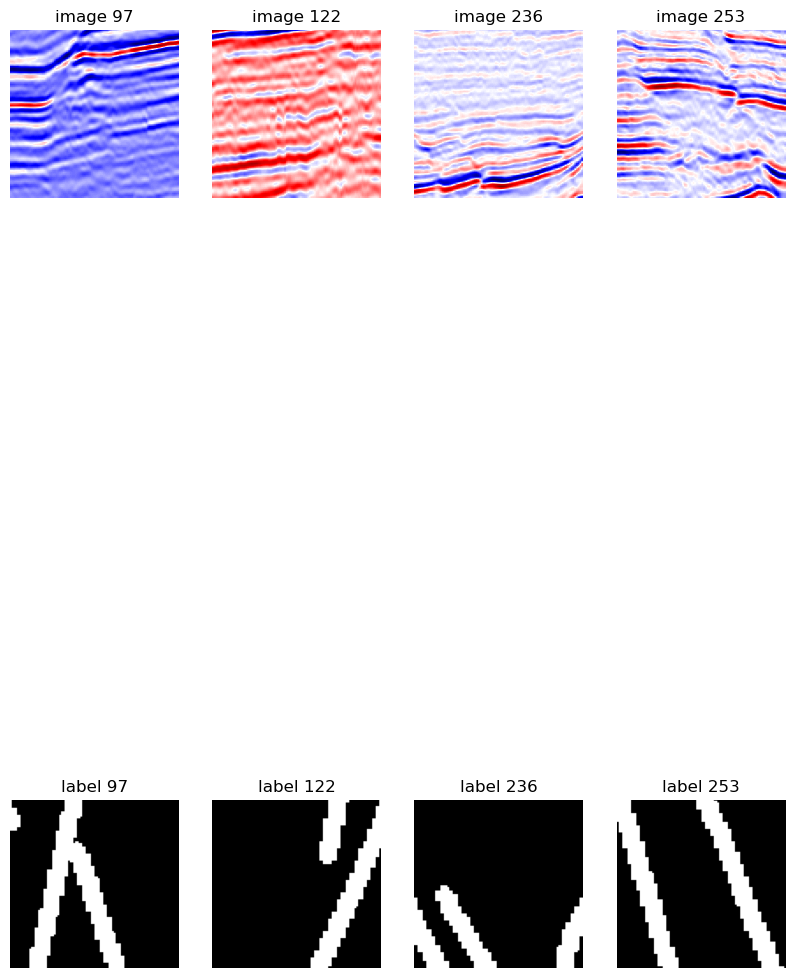

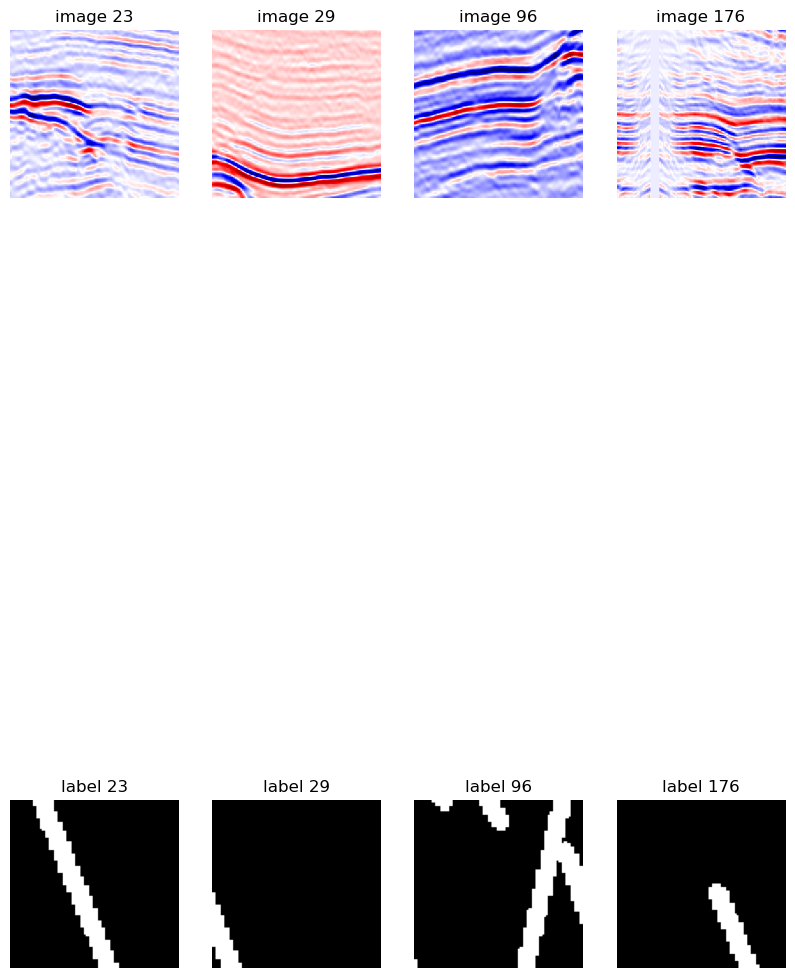

In [7]:
if INTERACTIVE_SESSION:
    X, y = next(train_dataset.as_numpy_iterator())
    # X, y = next(val_dataset.as_numpy_iterator())
    thebe_data.display_sample_images(X, y, num_images=4)
    thebe_data.display_sample_images(X, y, num_images=4)


In [8]:
# Model configurations
conf = model_config(
    epochs=100,
    batch_size=BATCH_SIZE,
    shuffle=True,
    scaling=1,
    save_path='./Thebe/new/unet0',
    img_shape=thebe_data.img_size,
    target_size=thebe_data.img_size,
    threshold=thebe_data.threshold,
    pos_label=thebe_data.pos_label,
    train_size=thebe_data.train_size,
    test_size=thebe_data.test_size,
    new_training_session=True,
    multiple_gpu_device=(NUM_GPU>1),
    validation_size=thebe_data.validation_size
)

callbacks = conf.callbacks(
    chkpt_monitor='val_f1_score', 
    es_monitor='val_loss',
    es_patience=100, 
    lr_monitor='val_loss',
)

conf.set( validation_data=val_dataset,  callbacks=callbacks )
m1 = f1_score(positive_label=thebe_data.pos_label, threshold=thebe_data.threshold)
conf.set(
    'compile', metrics= ['accuracy', m1]
)

# conf.double_check(INTERACTIVE_SESSION)
conf.info()

             NUM_GPU: 1
        augmentation: False
        channels_dim: (1, 1)
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
                       metrics: accuracy
                              : f1_score(name=f1_score,dtype=float32)
           img_shape: (96, 96)
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: True
           pos_label: 1
           save_path: ./Thebe/new/unet0
             scaling: 1
         target_size: (96, 96)
           test_size: 224122
           threshold: 0.5
          train_size: 181029
       training_args:
                        epochs: 100
                    batch_size: 256
                       shuffle

### Build  model 

In [9]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    # strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")
    with strategy.scope():
        conf = model_config(
            epochs=100,
            batch_size=BATCH_SIZE,
            shuffle=True,
            scaling=1,
            save_path='./Thebe/new/unet0',
            img_shape=thebe_data.img_size,
            target_size=thebe_data.img_size,
            threshold=thebe_data.threshold,
            pos_label=thebe_data.pos_label,
            train_size=thebe_data.train_size,
            test_size=thebe_data.test_size,
            new_training_session=True,
            multiple_gpu_device=(NUM_GPU>1),
            validation_size=thebe_data.validation_size
        )

        callbacks = conf.callbacks(
            chkpt_monitor='val_f1_score', 
            es_monitor='val_loss',
            es_patience=100, 
            lr_monitor='val_loss',
        )

        conf.set( validation_data=val_dataset,  callbacks=callbacks )
        m1 = f1_score(positive_label=thebe_data.pos_label, threshold=thebe_data.threshold)
        conf.set(
            'compile',
            metrics= ['accuracy', m1]
        )

        m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        #m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        model = m_obj.build_model()
        model.compile(**conf.compile_args)

else:

    m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    #m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    model = m_obj.build_model()
    model.compile(**conf.compile_args)


# model.summary()
# keras.utils.plot_model(model, 'm_obj.png',show_shapes=True)
# plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


Total number of parameters: 1,952,417
Total trainable wieghts: 1,949,601
Total non-trainable wieghts: 2,816


### Train  model



	Train unet model
-------------------------------------------------------
Model training...


2024-06-01 18:02:32.340304: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-NET/sequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2024-06-01 18:02:33.948861: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


2024-06-01 18:02:55.509803: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa85c7de830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-01 18:02:55.509867: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-06-01 18:02:55.675873: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


I0000 00:00:1717257776.785283 2794204 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.



Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.



Epoch 57: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.



Epoch 67: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.



Epoch 86: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.



Epoch 96: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.


training elapsed time: ___212.84___ minutes
...training completed!


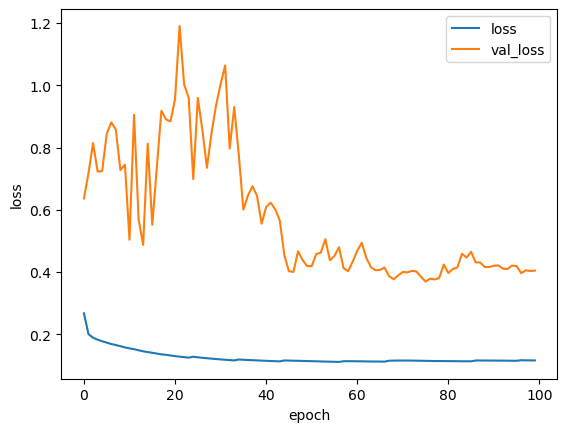

In [10]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=train_dataset, 
        plot_history=INTERACTIVE_SESSION
)


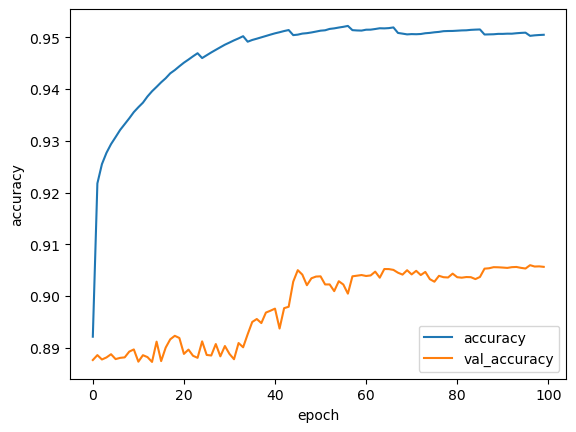

In [11]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, ['accuracy','val_accuracy'])

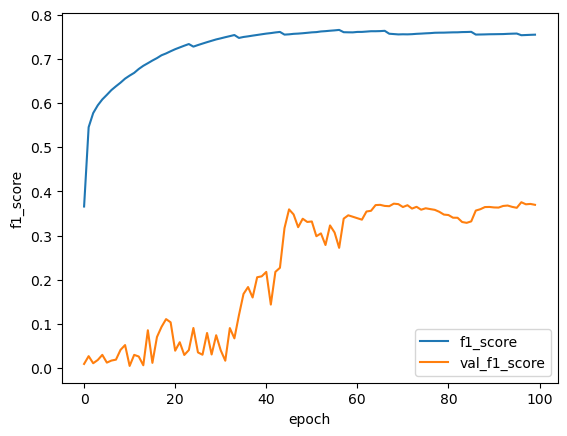

In [12]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, ['f1_score','val_f1_score'])

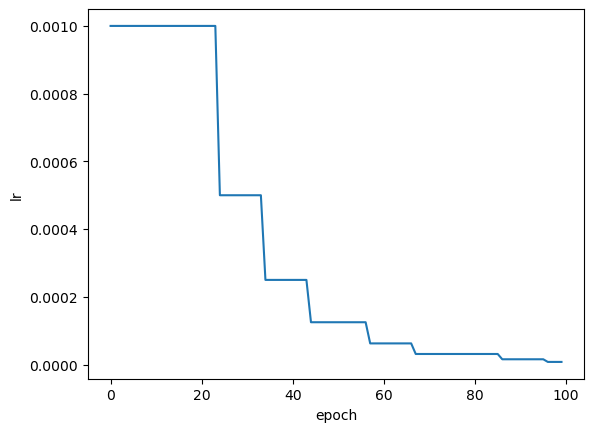

In [13]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, 'lr')

### Evaluate and Vizualize

In [14]:
#print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))
#y_pred = model.predict(x_test)


In [15]:

#if INTERACTIVE_SESSION:
#    thebe_data.display_sample_images(x_test, y_test, y_pred)
    

In [16]:
#model.evaluate(x=x_test)


In [17]:

#scores = conf.evaluate_sklearn(y_test, y_pred,report=True)
#print(scores)